In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-13 14:30:21.058982: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 14:30:21.088986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:30:21.115324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:30:21.115477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1111084654030319884
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6091374592
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13212859232150878344
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./reformattedData_20220531/All_cases_100x100_per500_zoom_2channels_10.hdf5', mode='r')
dataset = h5.get('phi')
# dataset.astype('int8')

# # Split into train and validation sets using indexing to optimize memory.
data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])
print(train_index)
print(val_index)

[ 0  1  2  4  5  6  7  8 11 13 14 15 16 17 18 19 20 23 24 25 26 27 28 29
 30 31 34 35 37 38 39 40 41 42 43 45 46 47 48 51 52 53 55 57 58 59 60 61
 62 63 64 66 70 72 74 75 77 79 80 81 82 83 84 85 86 87]
[ 3  9 10 12 21 22 32 33 36 44 49 50 54 56 65 67 68 69 71 73 76 78 88]


In [4]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

dataset.shape

(89, 70, 100, 100, 3)

In [5]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x, y

def create_shifted_frames_3to3(data):
    x1 = np.expand_dims(data[:, 0 : data.shape[1] - 3, :, :, 0],4)
    x2 = np.expand_dims(data[:, 0 : data.shape[1] - 3, :, :, 1],4)
    x3 = np.expand_dims(data[:, 1 : data.shape[1] - 2, :, :, 0],4)
    x4 = np.expand_dims(data[:, 1 : data.shape[1] - 2, :, :, 1],4)
    x5 = np.expand_dims(data[:, 2 : data.shape[1] - 1, :, :, 0],4)
    x6 = np.expand_dims(data[:, 2 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3,x4,x5,x6), axis=4)
    y1 = np.expand_dims(data[:, 3 : data.shape[1], :, :, 0],4)
    y2 = np.expand_dims(data[:, 3 : data.shape[1], :, :, 1],4)
    y = np.concatenate((y1,y2), axis=4)
    # y = np.expand_dims(data[:, 3 : data.shape[1], :, :, 0],4)
    return x,y

def create_shifted_frames_1to1(data):
    x1 = np.expand_dims(data[:, 1 : data.shape[1] - 1, :, :, 0],4)
    x2 = np.expand_dims(data[:, 1 : data.shape[1] - 1, :, :, 1],4)
    x3 = np.expand_dims(data[:, 1 : data.shape[1] - 1, :, :, 2],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = np.expand_dims(data[:, 2 : data.shape[1], :, :, 0],4)
    # y = np.expand_dims(data[:, 3 : data.shape[1], :, :, 0],4)
    return x,y

def create_shifted_frames_5to1(data):
    x1 = np.expand_dims(data[:, 0 : data.shape[1] - 5, :, :, 0]+data[:, 0 : data.shape[1] - 5, :, :, 1],4)
    x2 = np.expand_dims(data[:, 1 : data.shape[1] - 4, :, :, 0]+data[:, 1 : data.shape[1] - 4, :, :, 1],4)
    x3 = np.expand_dims(data[:, 2 : data.shape[1] - 3, :, :, 0]+data[:, 2 : data.shape[1] - 3, :, :, 1],4)
    x4 = np.expand_dims(data[:, 3 : data.shape[1] - 2, :, :, 0]+data[:, 3 : data.shape[1] - 2, :, :, 1],4)
    x5 = np.expand_dims(data[:, 4 : data.shape[1] - 1, :, :, 0]+data[:, 4 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3,x4,x5), axis=4)
    y = data[:, 5 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x,y

def create_shifted_frames_3to1(data):
    x1 = np.expand_dims(data[:, 1 : data.shape[1] - 3, :, :, 0]+data[:, 1 : data.shape[1] - 3, :, :, 1],4)
    x2 = np.expand_dims(data[:, 2 : data.shape[1] - 2, :, :, 0]+data[:, 2 : data.shape[1] - 2, :, :, 1],4)
    x3 = np.expand_dims(data[:, 3 : data.shape[1] - 1, :, :, 0]+data[:, 3 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = data[:, 4 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x,y

# Apply the processing function to the datasets.
# x_train, y_train = create_shifted_frames(train_dataset)
# x_val, y_val = create_shifted_frames(val_dataset)
x_train, y_train = create_shifted_frames_3to1(train_dataset)
x_val, y_val = create_shifted_frames_3to1(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (66, 66, 100, 100, 3), (66, 66, 100, 100, 1)
Validation Dataset Shapes: (23, 66, 100, 100, 3), (23, 66, 100, 100, 1)


Displaying frames for example 44.


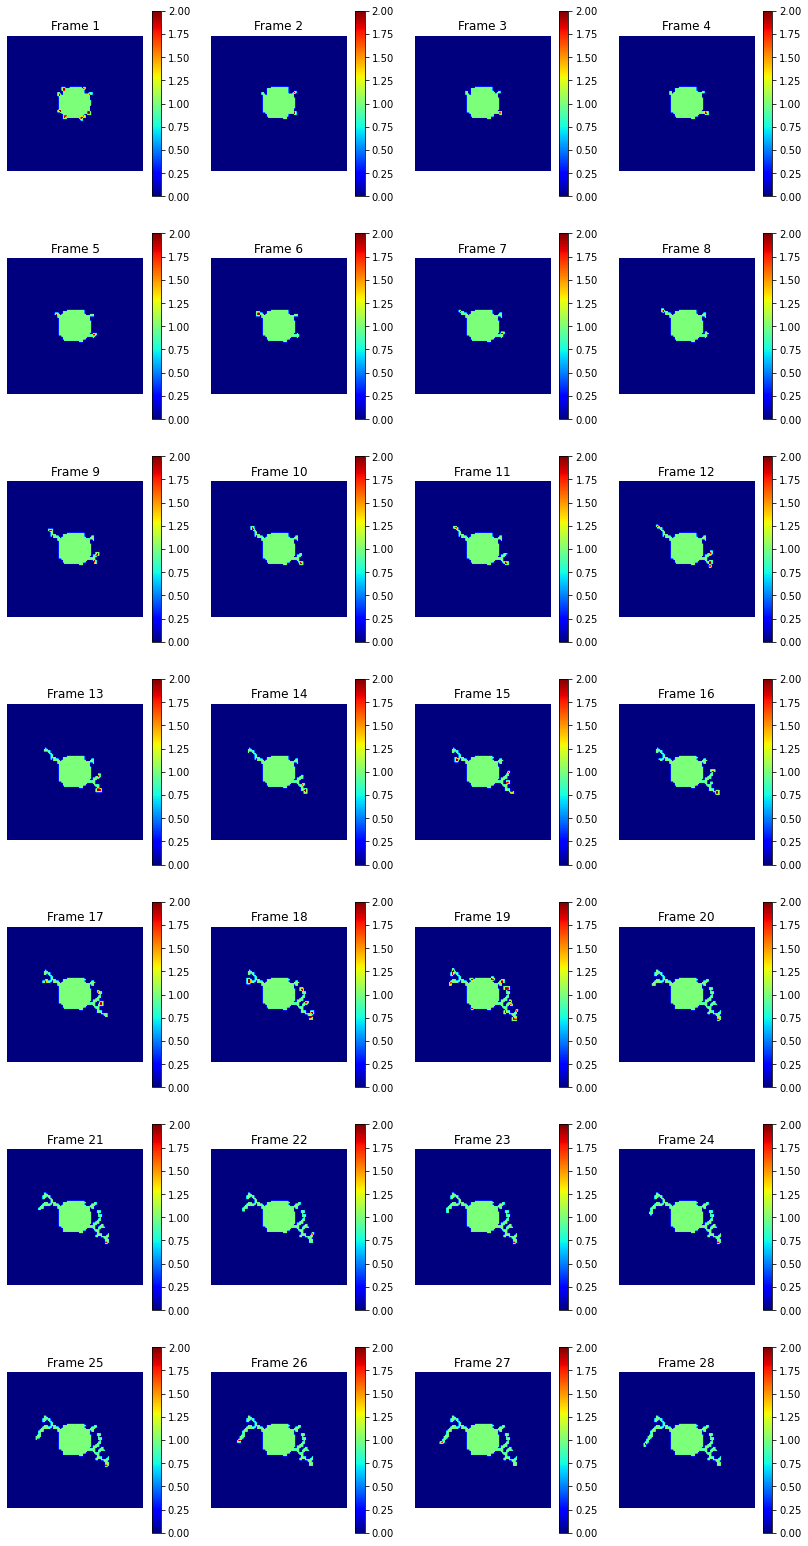

In [6]:
# Construct a figure on which we will visualize the images.
# fig, axes = plt.subplots(7, 4, figsize=(14, 28))
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(x_train)), size=1)[0]
fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(x_train[data_choice][idx][:,:,0]),cmap='jet')
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

Displaying frames for example 44.


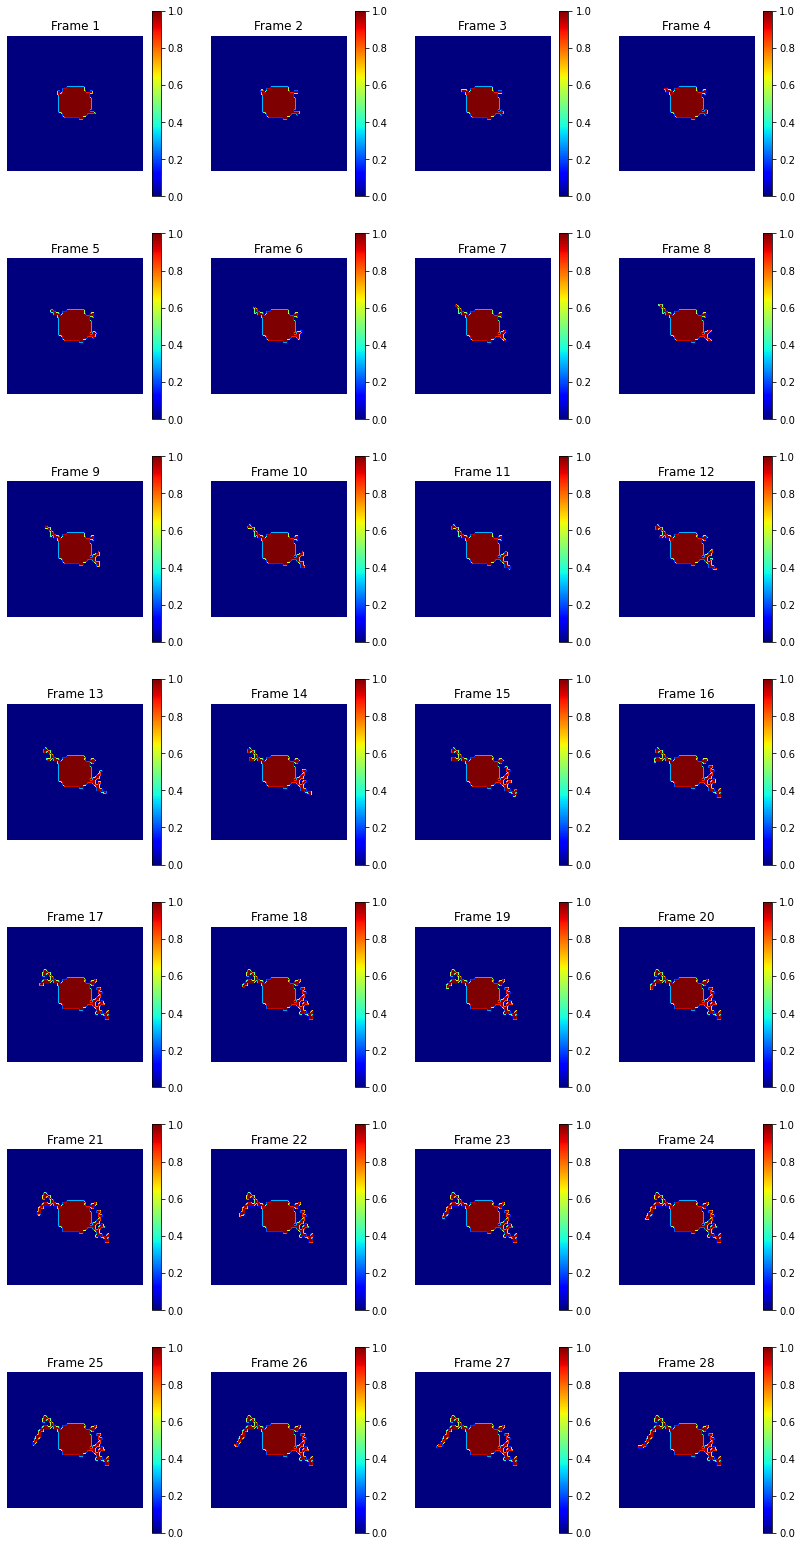

In [7]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(y_train[data_choice][idx][:,:,0]), cmap="jet")
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [8]:
# # Construct the input layer with no definite frame size.
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# x0 = layers.TimeDistributed(layers.Conv2D(
#     filters=64,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(inp)
# x1 = layers.TimeDistributed(layers.Conv2D(
#     filters=128,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x0)
# x2 = layers.ConvLSTM2D(
#     filters=128,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x1)
# x3 = layers.Concatenate(axis=4)([x1,x2])
# x4 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=64,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x3)
# x5 = layers.Concatenate(axis=4)([x0,x4])
# x6 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x5)
# # x6 = keras.backend.k_round(x6)

In [9]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

drop_rate = 0.1
x0 = layers.TimeDistributed(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x0 = layers.Dropout(drop_rate)(x0)
# x0 = layers.TimeDistributed(layers.BatchNormalization())(x0)
x1 = layers.TimeDistributed(layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
x1 = layers.Dropout(drop_rate)(x1)
# x1 = layers.TimeDistributed(layers.BatchNormalization())(x1)
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    recurrent_dropout=drop_rate,
)(x1)
# x2 = layers.TimeDistributed(layers.BatchNormalization())(x2)
x3 = layers.Concatenate(axis=4)([x1,x2])
x4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x3)
x4 = layers.Dropout(drop_rate)(x4)
# x4 = layers.TimeDistributed(layers.BatchNormalization())(x4)
x5 = layers.Concatenate(axis=4)([x0,x4])
x6 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(x5)
x6 = layers.Dropout(drop_rate)(x6)
# x6 = layers.TimeDistributed(layers.BatchNormalization())(x6)

2022-06-13 14:31:03.527055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:31:03.527214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:31:03.527317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:31:03.527542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:31:03.527652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
model = keras.models.Model(inp, x6)
model.compile(
    # loss=keras.losses.BinaryCrossentropy(reduction="auto", name="binary_crossentropy"),
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 3)]                                                          
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 48, 48  4864       ['input_1[0][0]']                
 ted)                           , 64)                                                             
                                                                                                  
 dropout (Dropout)              (None, None, 48, 48  0           ['time_distributed[0][0]']       
                                , 64)                                                         

In [11]:
test = True

if test == True:
    model = keras.models.load_model('./tmp/model_conv_lstm_14')
else:
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 500
    batch_size = 2

    # with tf.device('/device:CPU:0'):
    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, reduce_lr],
        )
    model.save('./tmp/model_conv_lstm_14') 

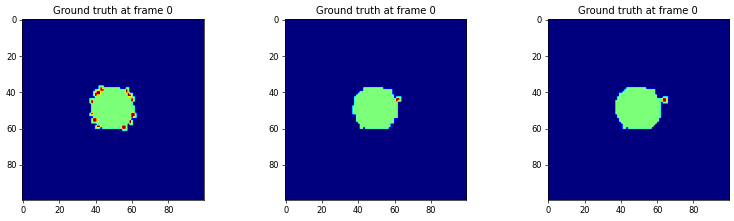

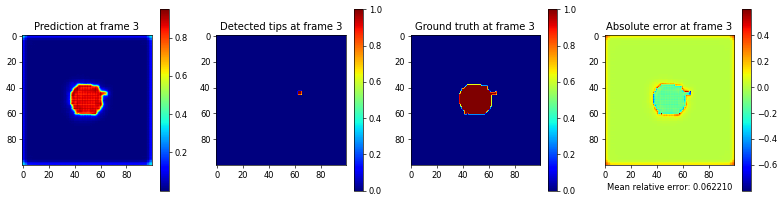

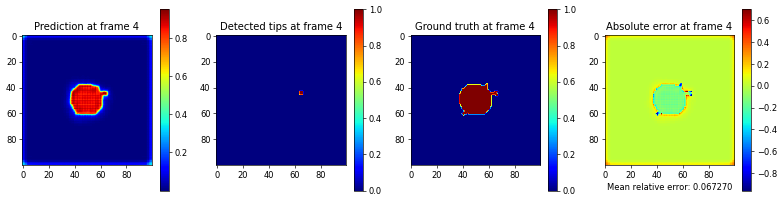

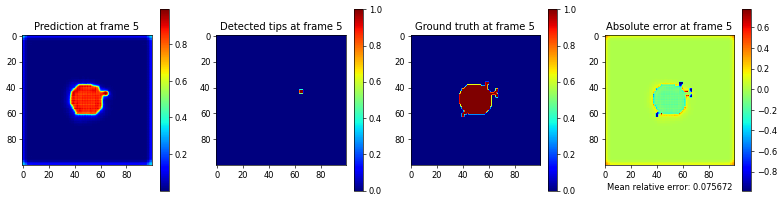

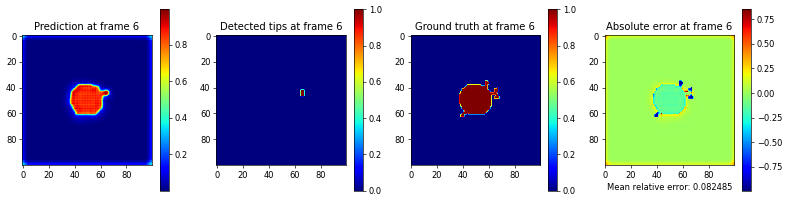

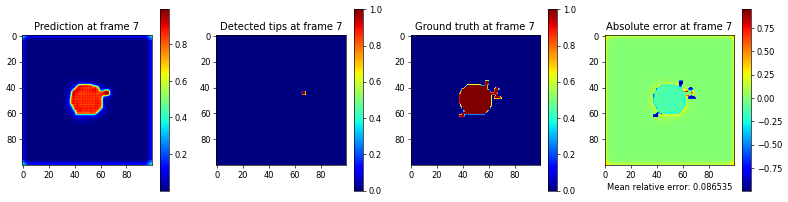

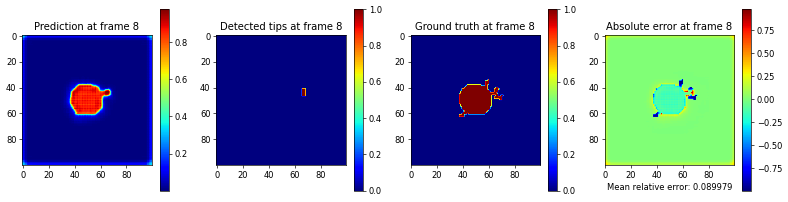

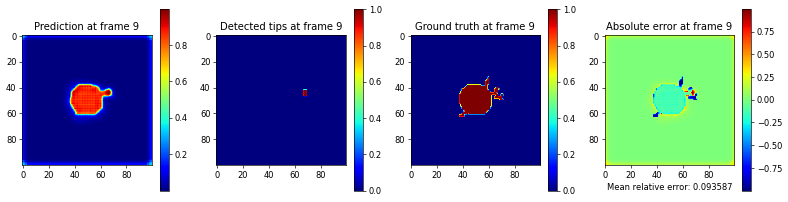

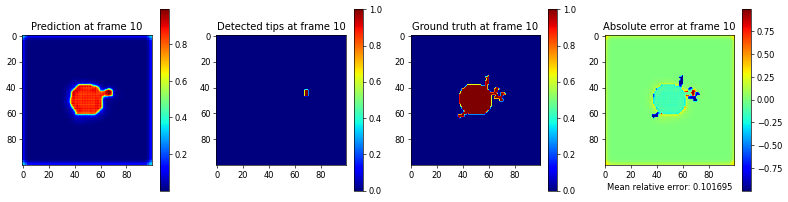

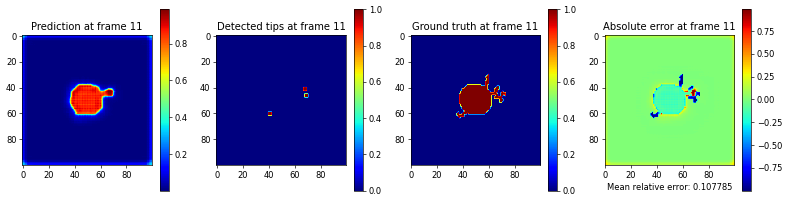

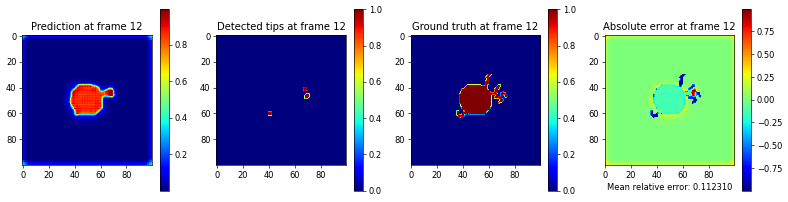

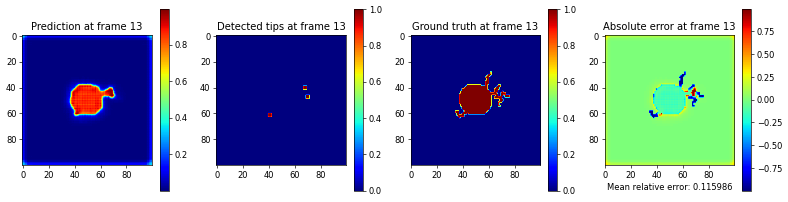

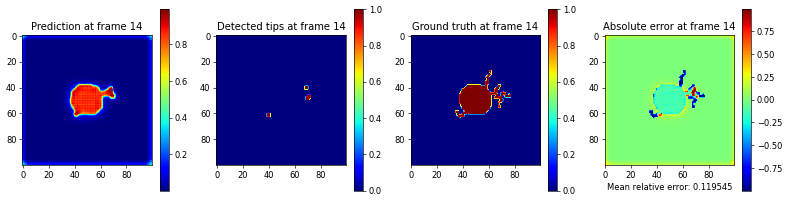

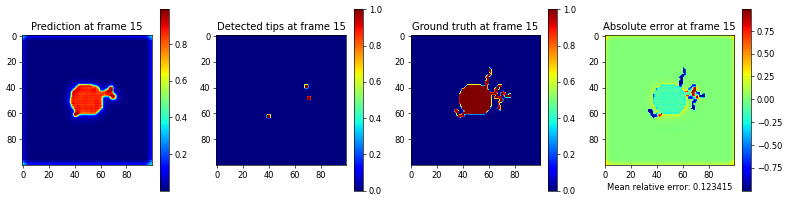

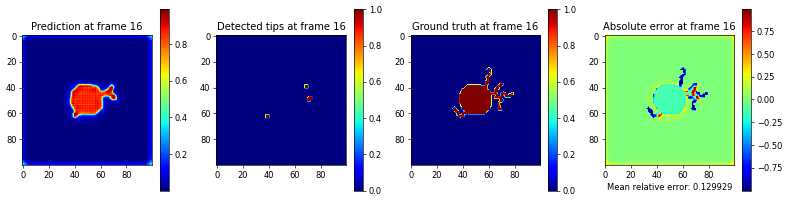

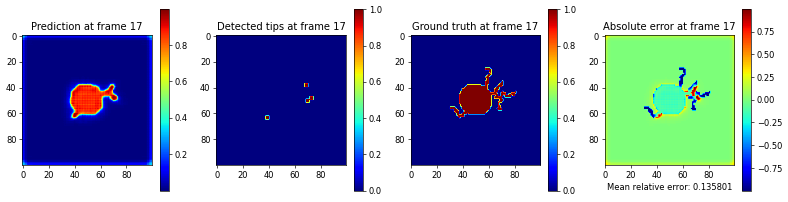

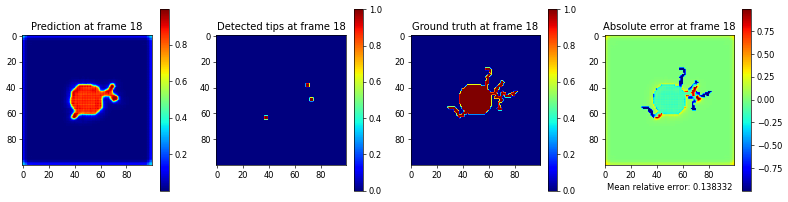

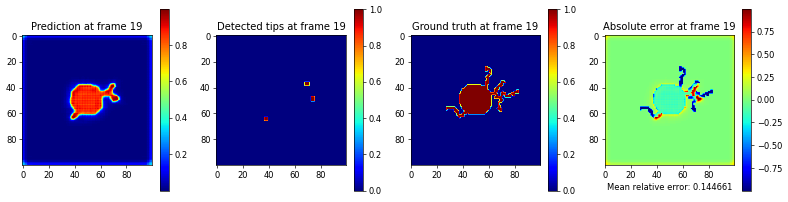

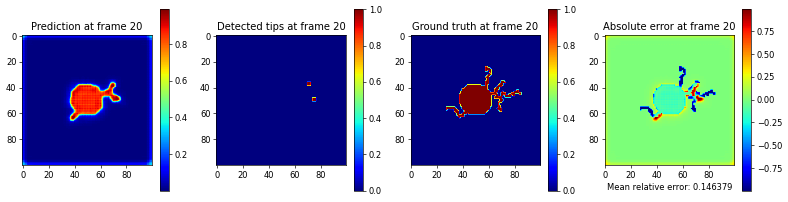

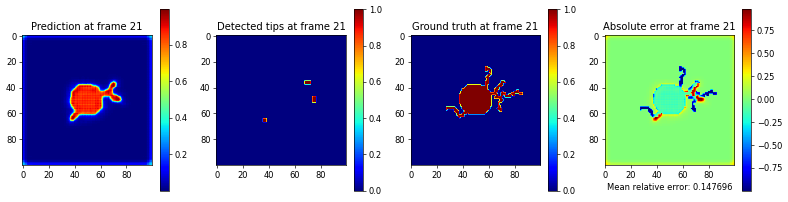

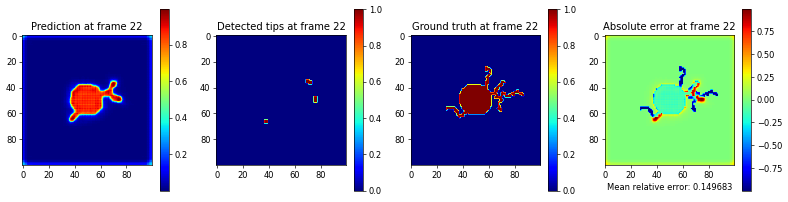

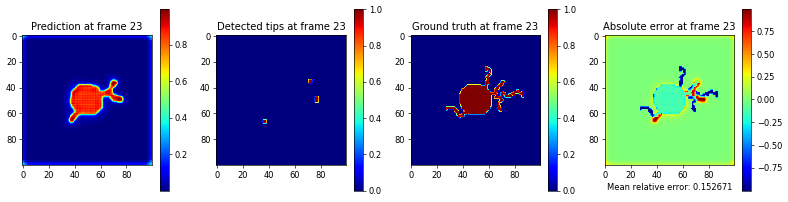

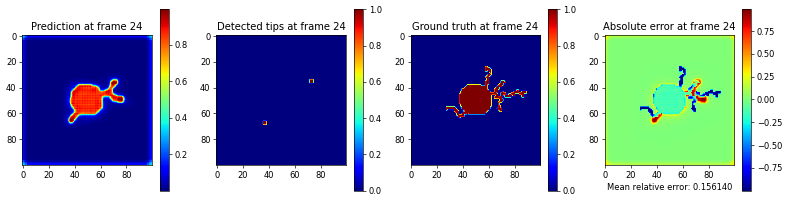

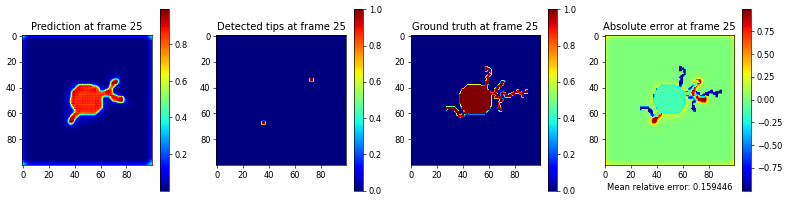

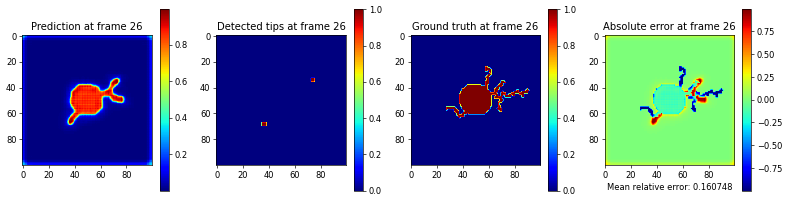

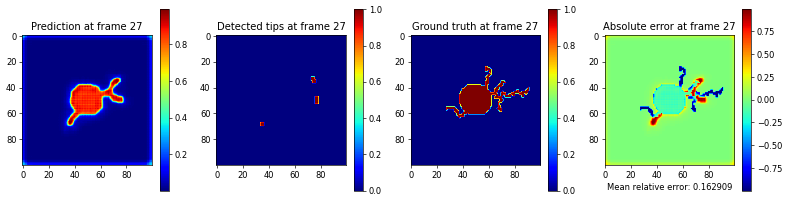

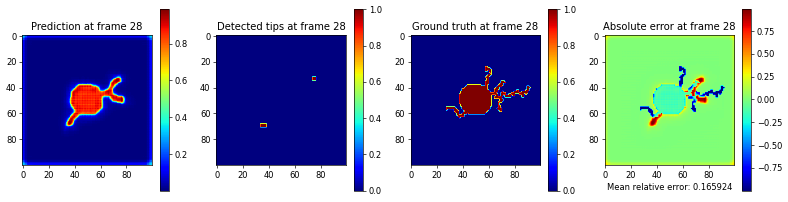

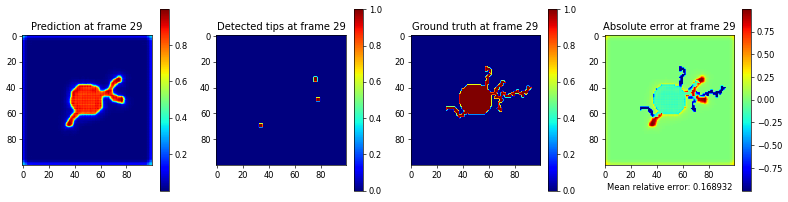

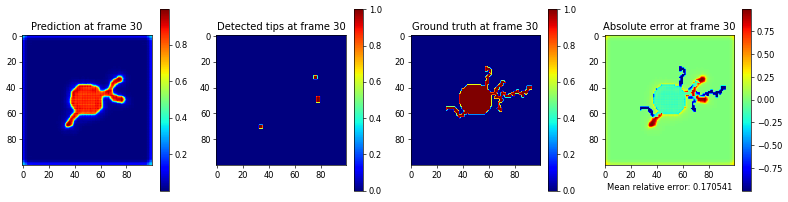

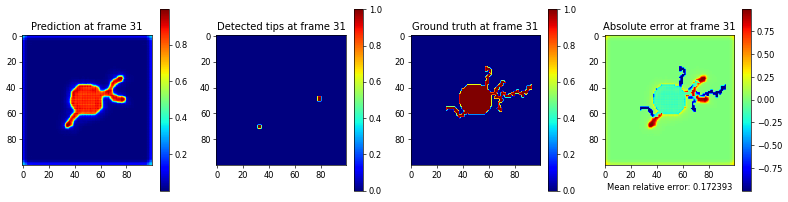

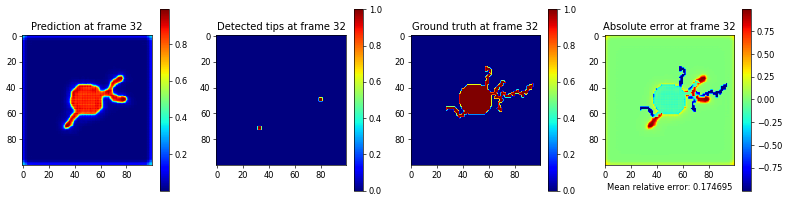

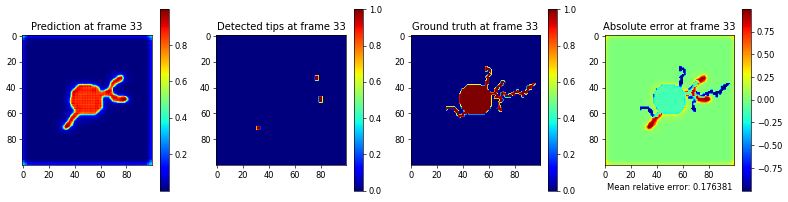

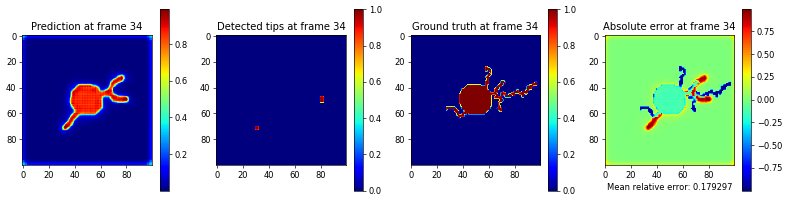

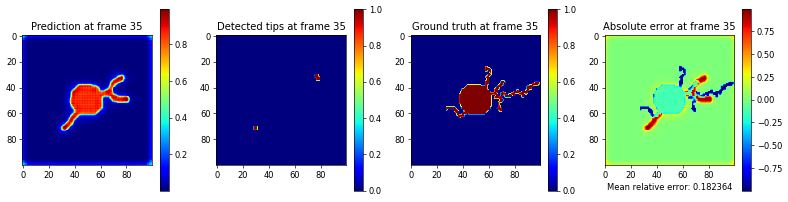

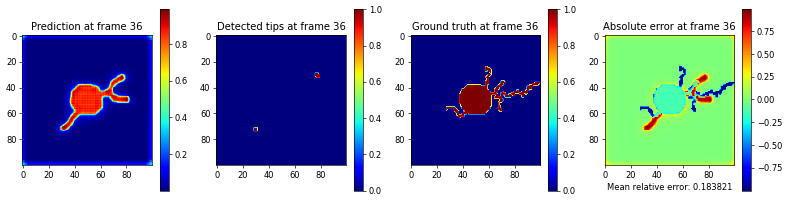

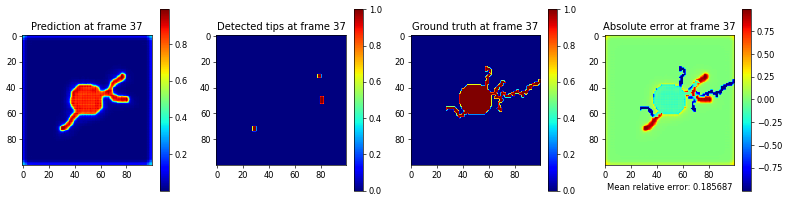

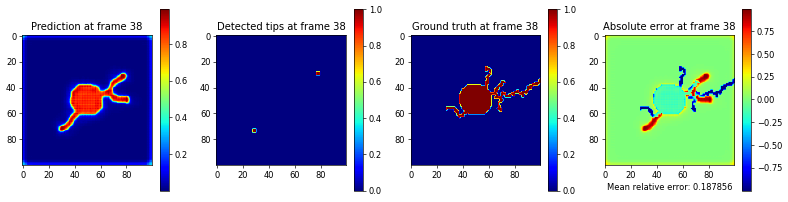

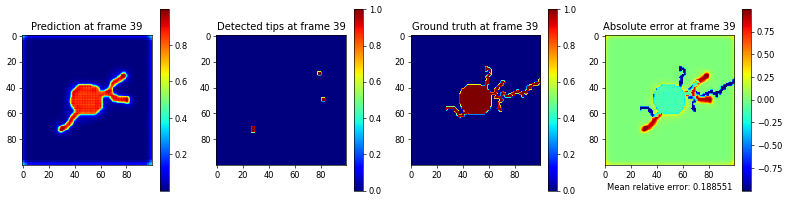

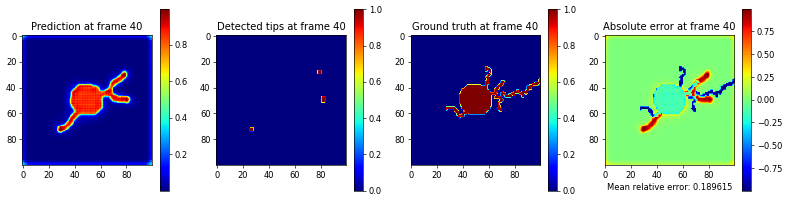

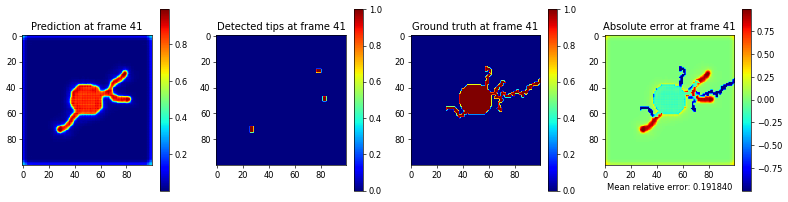

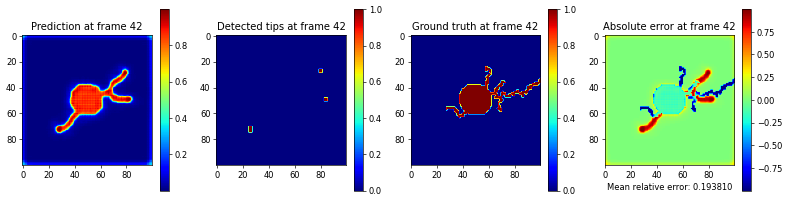

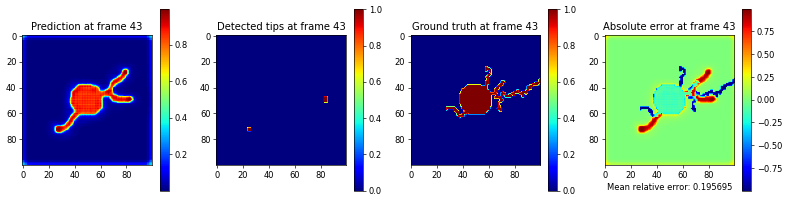

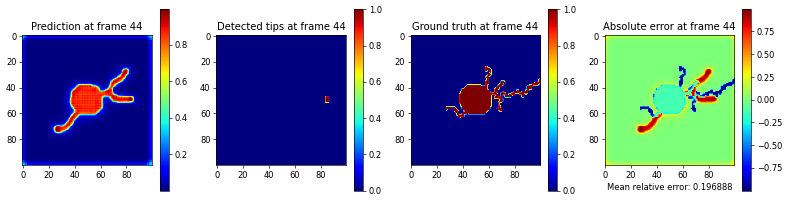

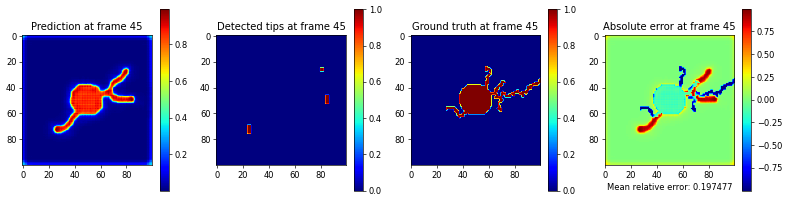

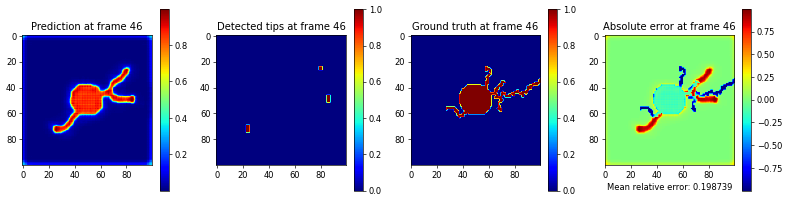

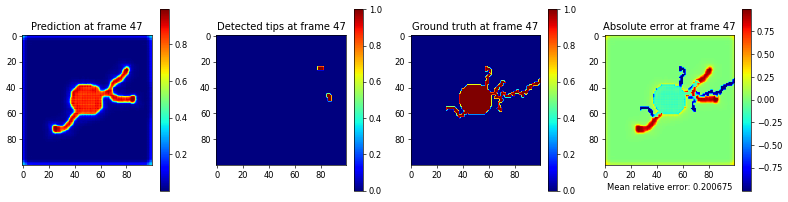

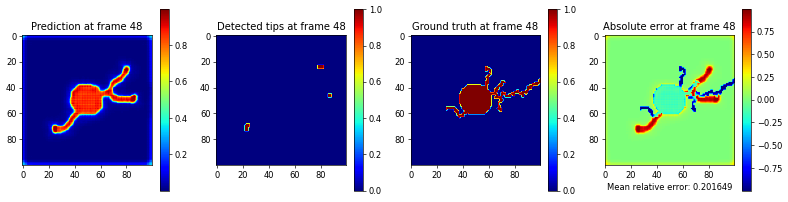

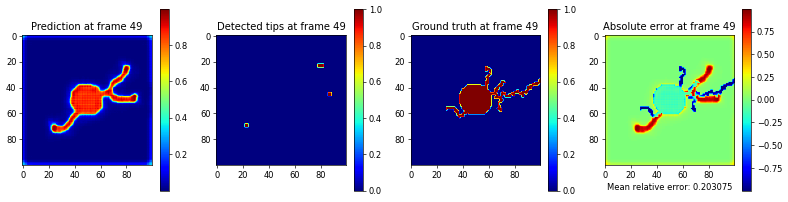

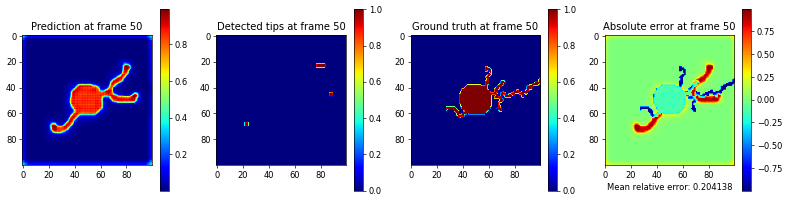

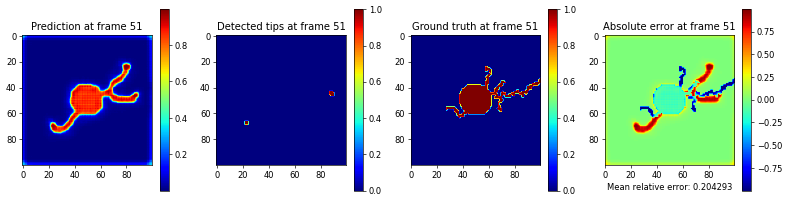

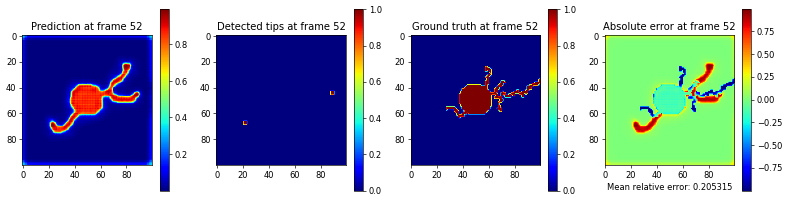

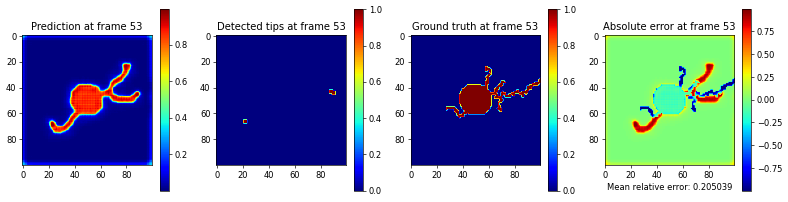

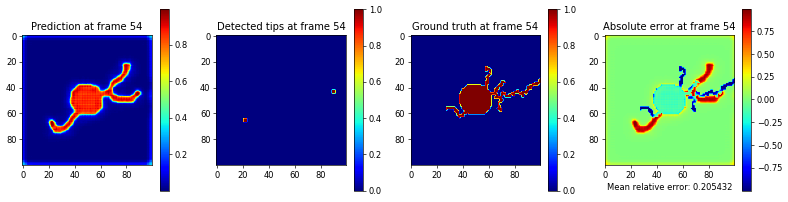

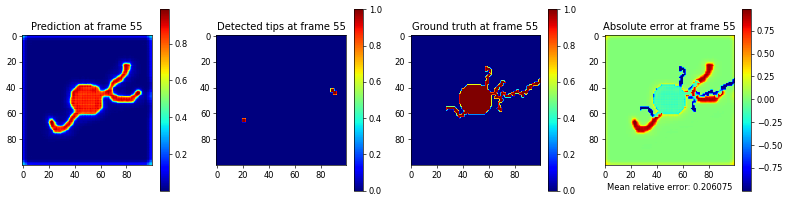

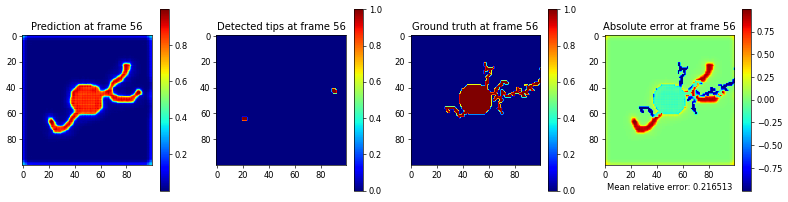

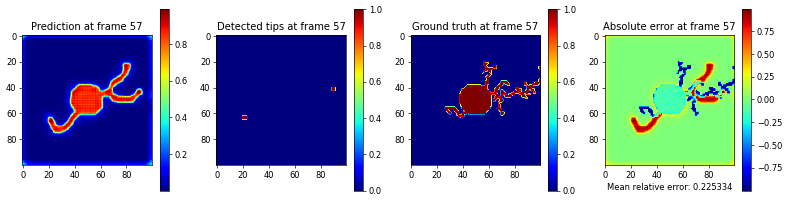

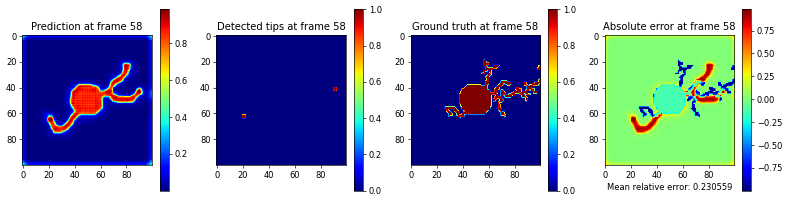

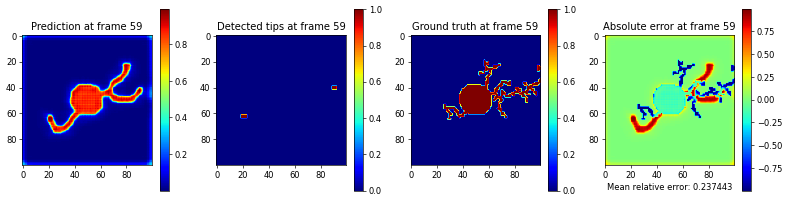

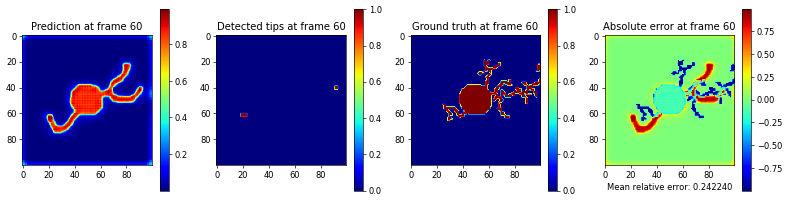

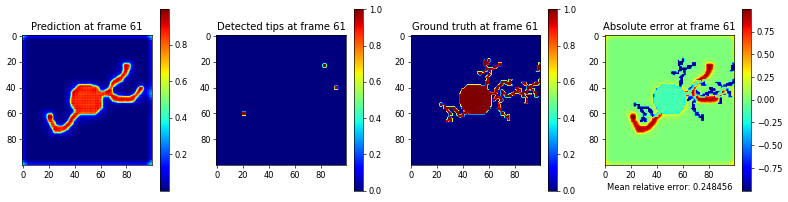

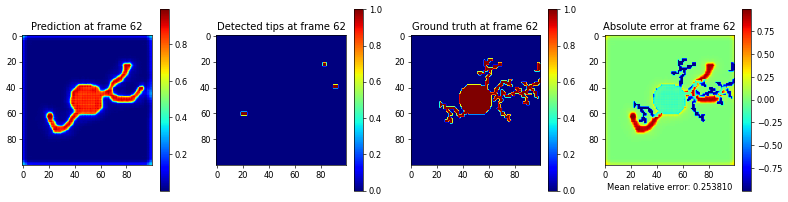

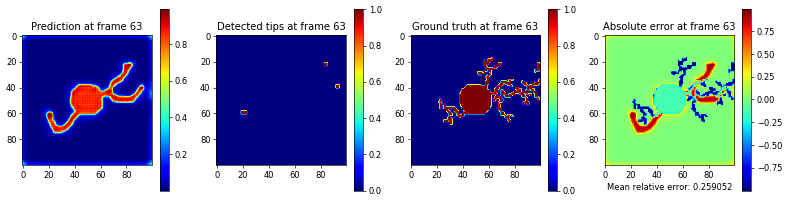

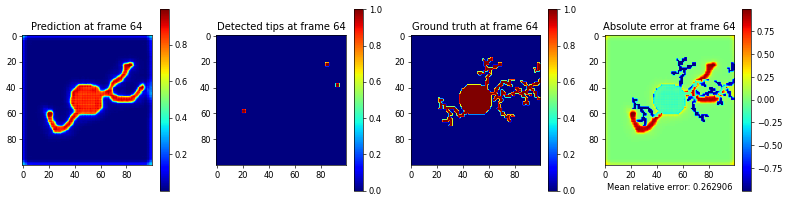

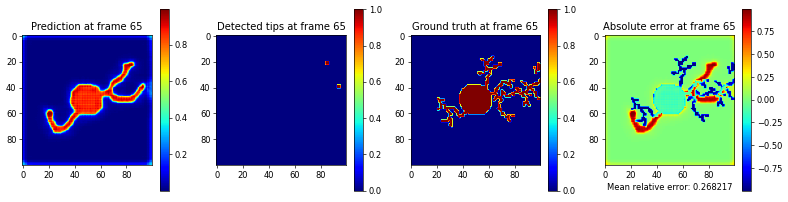

In [33]:
import matlab.engine
eng = matlab.engine.start_matlab()

rand_case = np.random.randint((len(val_dataset)))

example_x = x_val[rand_case,...]
example_y = y_val[rand_case,...]
# example_theta = theta_val[rand_case,...]

plt.figure(figsize=(16, 4), dpi=60)
plt.subplot(1,3,1)
plt.imshow(example_x[0,:,:,0], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,2)
plt.imshow(example_x[0,:,:,1], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,3)
plt.imshow(example_x[0,:,:,2], cmap='jet')
plt.title('Ground truth at frame 0')
plt.savefig("./Figure/frame_0to3.png")
plt.show()

x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

for i in range(example_x.shape[0]-3):

    new_prediction = model.predict(x_in)
    temp = np.zeros([1,1,100,100,3])

    tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
    # tips_theta = np.multiply(tips,example_x[0,:,:,2],example_theta)
    # tips_theta=tips
    # temp_phi = np.round(new_prediction[0,0,:,:,0])+tips
    # need to double check, also test 9
    # temp_phi[tips==0] = tips_theta[tips==0] 
    temp[0,0,:,:,0] = x_in[0,0,:,:,1]
    temp[0,0,:,:,1] = x_in[0,0,:,:,2]
    temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

    x_in = temp

    mre = np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3])))

    plt.figure(figsize=(16, 4), dpi=60)

    plt.subplot(1,4,1)
    plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Prediction at frame %d'%(i+3))

    plt.subplot(1,4,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title('Detected tips at frame %d'%(i+3))

    plt.subplot(1,4,3)
    plt.imshow(example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Ground truth at frame %d'%(i+3))

    plt.subplot(1,4,4)
    plt.imshow(new_prediction[0,0,:,:,0]-example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Absolute error at frame %d'%(i+3))
    plt.xlabel('Mean relative error: %f'%mre)

    plt.savefig("./Figure/frame_%d.png"%(i+3))
    plt.show()
    
eng.quit()
